# Data Preparation

In [1]:
#import libraries

import pandas as pd
import seaborn as sns
import numpy as np

#data rebalancing
from imblearn.over_sampling import SMOTE, RandomOverSampler

#normalization
from sklearn import preprocessing

#classification
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# bool columns in dataframe
global bool_columns
bool_columns = ['Smokes','Hormonal Contraceptives', 'IUD', 'STDs',
                'STDs:condylomatosis', 'STDs:cervical condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease', 
                'STDs:genital herpes', 'STDs:molluscum contagiosum',
                'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV',
                'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']

# Function definitions

In [3]:
def meanImputation(df):
    """Data imputation using mean/mode of columns
    Following the methods described in: Razaliet al. (2020).
    Risk Factors of Cervical Cancer using Classification in Data Mining.
    Journal of Physics: Conference Series. 1529. 022102. 10.1088/1742-6596/1529/2/022102.

    Missing values for attribute that have integer data type were filled using the sample mean
    while boolean were filled using the sample mode.
    """
        
    # replace NaN with mode for columns with dtype bool
    for label, col in df.iteritems():
        if label in bool_columns:
            columns_mode = col.mode()
            # method 1
            df[label] = col.fillna(columns_mode[0])

            #convert column to bool while we're at it
            df[label] = df[label].astype('bool')

    float_columns = df.select_dtypes(include=['float64']).columns

    # replace NaN with mean for columns with dtype float
    for col in float_columns:
        columns_mean = df[col].mean()
        df[col] = df[col].fillna(columns_mean)
        
    return df

# Custom transformers

## Data imputation

Method 1: MeanImputationTransformer
Following the methods described in:
Razali, Nazim & Mostafa, Salama & Mustapha, Aida & Abd Wahab, Mohd Helmy & Ibrahim, Nurul. (2020). Risk Factors of Cervical Cancer using Classification in Data Mining. Journal of Physics: Conference Series. 1529. 022102. 10.1088/1742-6596/1529/2/022102. 

"Missing values for attribute that have integer data type were filled using the sample mean while boolean
were filled using the sample mode."

Method 2: UniqueValueImputationTransformer
Sets unique value -99 everywhere where data is missing. Value is chosen as it doesn't have any real-life meaning.

In [4]:
class MeanImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #print("Mean value imputation called.")
        X_ = X.copy() # create copy to avoid changes to original dataset
        X_ = meanImputation(X_)
        return X_

In [5]:
class UniqueValueImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        #print("Unique value imputation called.")
        X_ = X.copy() # create copy to avoid changes to original dataset
        X_ = X_.fillna(-99)
        return X_

# Loading Dataset

In [6]:
# https://archive-beta.ics.uci.edu/ml/datasets/cervical+cancer+risk+factors
"""
The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela.
The dataset comprises demographic information, habits, and historic medical records of 858 patients.
Several patients decided not to answer some of the questions because of privacy concerns (missing values).
"""

rf = pd.read_csv('risk_factors_cervical_cancer.csv',encoding='utf8')
#rf.info()

# Covert data to usable datatypes

In [7]:
# replace missing values with NaN
rf = rf.replace('?',np.nan)

# covert everything to float64, some classes will be converted to bool once missing values are taken care of
for label, col in rf.iteritems():
    rf[label] = pd.to_numeric(col, errors='coerce')

#TODO: some things are still int after this and object types get transformed to bool automatically. But NaN values
#are not falsly converted to True so that should be okay.

# Examine data

## Check missing values per column

In [8]:
percent_missing = rf.isnull().sum() * 100 / len(rf)
missing_value_df = pd.DataFrame({'column_name': rf.columns,
                                 'percent_missing': percent_missing})

In [9]:
# remove columns with more than 20% missing
selection_columns = missing_value_df.loc[missing_value_df['percent_missing'] >= 20].iloc[:, 0]

for col in selection_columns:
    rf = rf.drop([col], axis=1)

## Check missing values per row

In [10]:
missing_count = []
for idx in range(len(rf)):
    missing = rf.loc[[idx]].isna().sum().sum()
    missing_count.append(missing)

removed = 0
for idx, val in enumerate(missing_count):
    # Remove all rows where more than 15% of the data are missing
    # If 20% is chosen, 106 patients are excluded
    if val >= len(rf.columns)*0.15:
        rf = rf.drop(idx)
        removed+=1
print("{} number of rows were removed".format(removed))

106 number of rows were removed


## Investigate class imbalances

In [11]:
# get number of patients per group
rf.groupby('Biopsy').count();

## Correlations between variables

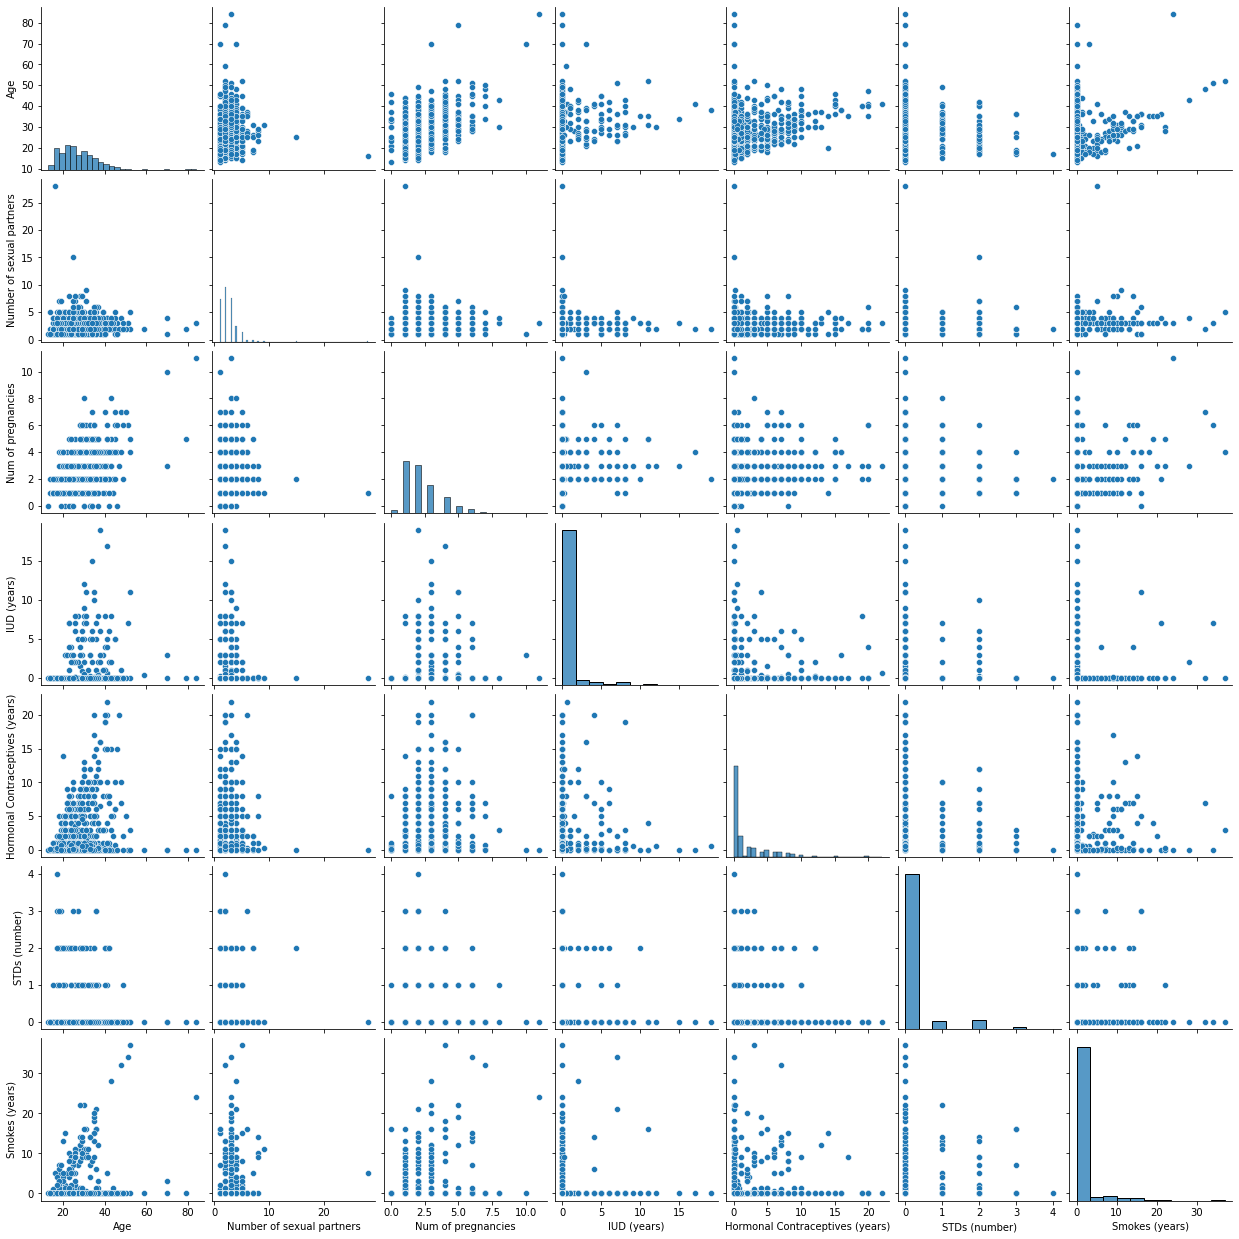

In [12]:
# Plot non-bool parameters
sns.pairplot(rf[['Age','Number of sexual partners','Num of pregnancies','IUD (years)',
                 'Hormonal Contraceptives (years)', 'STDs (number)', 'Smokes (years)']]);

## Investigate STDs (number) vs STDs: Number of diagnosis

In [13]:
# check if STDs (number) and STDs: Number of diagnosis are the same
STD_comparison = np.where((rf['STDs (number)']==rf['STDs: Number of diagnosis']), True, False)

# check manual calculation with STDs(number) if STDS (number) and STDs: Number of diagnosis not the same
if not STD_comparison.all():
    # create a new column with the sum of all STDs
    rf['STDs (number manual)'] = (rf['STDs:condylomatosis'] + rf['STDs:cervical condylomatosis'] +
        rf['STDs:vaginal condylomatosis'] + rf['STDs:vulvo-perineal condylomatosis'] +
        rf['STDs:syphilis'] + rf['STDs:pelvic inflammatory disease'] +
        rf['STDs:genital herpes'] + rf['STDs:molluscum contagiosum'] +
        rf['STDs:AIDS'] + rf['STDs:HIV'] +
        rf['STDs:Hepatitis B'] + rf['STDs:HPV'])
    
    # if they're the same drop the new column again
    manual_comp = np.where((rf['STDs (number)']==rf['STDs (number manual)']), True, False)
    if manual_comp.all():
        rf = rf.drop(['STDs (number manual)'], axis=1)

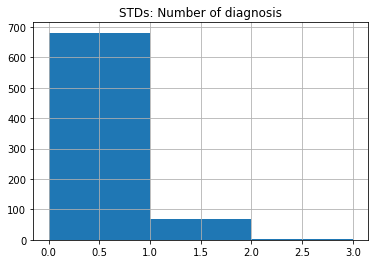

In [14]:
# STDs: Number of diagnosis is also not the same as just STDs
STD_comparison = np.where((rf['STDs']==rf['STDs: Number of diagnosis']), True, False).all() #=False

# is STDs: Number of diagnosis a encoded value?
minimum = rf['STDs: Number of diagnosis'].min() #=0
maximum = rf['STDs: Number of diagnosis'].max() #=3
# unlikely that it's the diagnosis code if the max is 3

# plot in histogram
ax = rf.hist(column=["STDs: Number of diagnosis"], bins=maximum)

# we don't know exactly what this column
# as our goal is to create a transparent model we decided to exclude the column
rf = rf.drop(['STDs: Number of diagnosis'], axis=1)

# Classification

## Create pipeline with random oversampling and unique value imputation

In [15]:
# split dataset in features and target variable
feature_cols = rf.columns[0:len(rf.columns)-4]
X = rf[feature_cols] # Features
y = rf.Biopsy # Target variable

In [16]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

In [17]:
# parameters for SMOTE oversampling
# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 1

In [18]:
# pipeline 1 using unique value imputation and random oversampling

pipe_1 = make_pipeline(UniqueValueImputationTransformer(), RandomOverSampler('minority'), ExplainableBoostingClassifier())
scores_1 = cross_val_score(pipe_1, X, y, cv=cv)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_1.mean(), scores_1.std()))
scores_1

0.87 accuracy with a standard deviation of 0.02


array([0.88053097, 0.88938053, 0.88495575, 0.84513274, 0.84513274])

In [19]:
# pipeline 2 using mean/mode value imputation and random oversampling

pipe_2 = make_pipeline(MeanImputationTransformer(), RandomOverSampler('minority'), ExplainableBoostingClassifier())
scores_2 = cross_val_score(pipe_2, X, y, cv=cv)
scores_2
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_2.mean(), scores_2.std()))
scores_2

0.88 accuracy with a standard deviation of 0.02


array([0.89380531, 0.89380531, 0.87168142, 0.86283186, 0.85840708])

In [20]:
# pipeline 3 using unique value imputation and smote oversampling

sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)

pipe_3 = make_pipeline(UniqueValueImputationTransformer(), sm, ExplainableBoostingClassifier())
scores_3 = cross_val_score(pipe_3, X, y, cv=cv)
scores_3
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_3.mean(), scores_3.std()))
scores_3

0.92 accuracy with a standard deviation of 0.01


array([0.92920354, 0.90265487, 0.9380531 , 0.9159292 , 0.90707965])

In [21]:
# pipeline 3 using mean/mode imputation and smote oversampling

sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)

pipe_4 = make_pipeline(MeanImputationTransformer(), sm, ExplainableBoostingClassifier())
scores_4 = cross_val_score(pipe_4, X, y, cv=cv)
scores_4
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_4.mean(), scores_4.std()))
scores_4

0.90 accuracy with a standard deviation of 0.01


array([0.90707965, 0.89823009, 0.92035398, 0.90265487, 0.88495575])